In [114]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [115]:
video = cv.VideoCapture("project2.avi")

# Display Video
if (video.isOpened()== False): 
  print("Error opening video stream or file")

points_list = []

# Read until video is completed
while(video.isOpened()):
  # read frame-by-frame
  ret, frame = video.read()
  if ret == True:
    
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    gaussian_blur = cv.GaussianBlur(gray,(7,7),cv.BORDER_DEFAULT)     
    canny = cv.Canny(gaussian_blur,125,200,apertureSize=3)

    # Display the resulting frame
    cv.imshow('Frame',canny)
 
    # Press Q on keyboard to  exit
    if cv.waitKey(25) & 0xFF == ord('q'):
      break

  else: 
    break

# When everything done, release the video videoture object
video.release()
 
# Closes all the frames
cv.destroyAllWindows()

### Hough Transformation

In [116]:
max_dist = np.sqrt(np.square(canny.shape[0])+np.square(canny.shape[1]))
theta = np.deg2rad(np.arange(-90.0, 90.0))
rho_range = np.arange(-max_dist, max_dist)

# Accumulator  (Voting Bin)
acc = np.zeros((len(rho_range),len(theta)),dtype=int)

y,x = np.nonzero(canny)

for i in range(len(x)):
    for j in range(len(theta)):
        rho = ((x[i] * np.cos(theta[j])) + (y[i] * np.sin(theta[j]))) + max_dist # Adding max_dist to get the minimum distance as zero
        # print(rho,", ",j)
        acc[round(rho),j] += 1

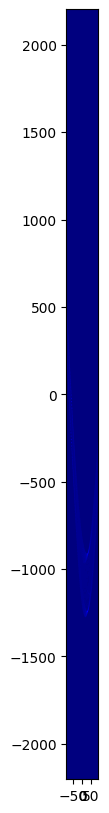

In [117]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(acc,cmap='jet', extent=[-90,90,-max_dist,max_dist])

In [118]:
peaks = []
acc1 = np.copy(acc)
for i in range(4):
    idx = np.argmax(acc1) # find argmax in flattened array
    acc1_idx = np.unravel_index(idx, acc1.shape) # remap to shape of acc
    peaks.append(acc1_idx)

    # surpess peaks in neighborhood
    idx_y, idx_x = acc1_idx # first separate x, y indexes from argmax(acc)
    # if idx_x is too close to the edges choose appropriate values
    if (idx_x - (3//2)) < 0: min_x = 0
    else: min_x = idx_x - (3//2)
    if ((idx_x + (3//2) + 1) > acc.shape[1]): max_x = acc.shape[1]
    else: max_x = idx_x + (3//2) + 1

    # if idx_y is too close to the edges choose appropriate values
    if (idx_y - (3//2)) < 0: min_y = 0
    else: min_y = idx_y - (3//2)
    if ((idx_y + (3//2) + 1) > acc.shape[0]): max_y = acc.shape[0]
    else: max_y = idx_y + (3//2) + 1

    # bound each index by the neighborhood size and set all values to 0
    for x in range(min_x, max_x):
        for y in range(min_y, max_y):
            # remove neighborhoods in acc1
            acc1[y, x] = 0

            # highlight peaks in original acc
            if (x == min_x or x == (max_x - 1)):
                acc[y, x] = 255
            if (y == min_y or y == (max_y - 1)):
                acc[y, x] = 255

peaks

[(3444, 122), (2247, 31), (2462, 29), (3112, 124)]

In [125]:
for i in range(len(peaks)):
    # reverse engineer lines from rho_range and thetas
    rho_peaks = rho_range[peaks[i][0]]
    theta_peaks = theta[peaks[i][1]]
    a = np.cos(theta_peaks)
    b = np.sin(theta_peaks)
    x0 = a*rho_peaks
    y0 = b*rho_peaks
    # these are then scaled so that the lines go off the edges of the image
    x1 = int(x0 + 2000*(-b))
    y1 = int(y0 + 2000*(a))
    x2 = int(x0 - 2000*(-b))
    y2 = int(y0 - 2000*(a))

    cv.line(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
cv.imshow('frame',frame)
cv.waitKey()
cv.destroyAllWindows()